# PREDICTING FLIGHT TICKET PRICES USING LINEAR REGRESSION

## INTRODUCTION

In this project, we are going to predict plane ticket prices with scikit-learn and Linear Regression. We will forecast the ticket prices based on many features such as the airline company, the source and destination city, the departure and arrival time, number of stops and so on.

The dataset can be found [here](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction). It contains 300153 datapoints and 11 features, including the target variable, price. Here are the features present in the dataset:

1) Airline: The name of the airline company.
2) Flight: The plane's flight code.
3) Source City: City from which the flight takes off.
4) Departure Time: Time when the plane departs.
5) Stops: Number of stops.
6) Arrival Time: Time when the plane arrives.
7) Destination City: City where the flight will land.
8) Class: Business/Economy.
9) Duration: The amount of time it takes to travel between cities in hours.
10) Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: The ticket price in INR(Indian Rupee).

We'll start with importing the required packages and reading the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 50)

df = pd.read_csv('flight_dataset.csv', index_col=0)
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


Let's see if we have any missing values.

In [2]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

We do not have any missing values. Now, we can proceed with splitting the data into a training set and a testing set.

In [3]:
X, y = df.drop(columns='price'), df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240122, 10), (60031, 10), (240122,), (60031,))

## NUMERIC FEATURES

### 'duration' and 'days_left'

In [4]:
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
148417,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Chennai,Economy,19.42,6
36879,Indigo,6E-2193,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,7.00,13
274531,Air_India,AI-768,Kolkata,Afternoon,one,Afternoon,Chennai,Business,21.17,44
166397,Vistara,UK-876,Hyderabad,Night,one,Early_Morning,Bangalore,Economy,10.25,11
272722,Vistara,UK-774,Kolkata,Night,one,Night,Chennai,Business,26.50,5


We can start with building our Linear Regression model using the numeric features. We will use the 'duration' and 'days_left' columns to predict the price. We will fit the model and evaluate the model performance using root mean square error or RMSE. RMSE is the average distance between the predictions and the true values. The lower the RMSE, the better the model.

In [5]:
def get_rmse():
    # Select numeric columns
    cols = X_train.select_dtypes(include='number').columns.tolist()

    # Fit a linear model and generate predictions
    model = LinearRegression().fit(X_train[cols], y_train)
    y_pred = model.predict(X_test[cols])

    # Calculate RMSE
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    
    print(f'Number of features used: {len(cols)}')
    print(f'RMSE: {RMSE:.3f} INR')
    return

In [6]:
get_rmse()

Number of features used: 2
RMSE: 22124.441 INR


On average, our predicted price differs from the actual price by 22k INR(~RM1180). This is pretty bad, but we have only used two features to predict the price and still have many features that we can use in order to improve our model performance.

## CATEGORICAL FEATURES

In [7]:
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
148417,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Chennai,Economy,19.42,6
36879,Indigo,6E-2193,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,7.00,13
274531,Air_India,AI-768,Kolkata,Afternoon,one,Afternoon,Chennai,Business,21.17,44
166397,Vistara,UK-876,Hyderabad,Night,one,Early_Morning,Bangalore,Economy,10.25,11
272722,Vistara,UK-774,Kolkata,Night,one,Night,Chennai,Business,26.50,5


Since most machine learning algorithms do not work with categorical values, they need to be encoded as numeric values. Let's take a look at how many unique values do we have for each column: 

In [8]:
for col in X_train.select_dtypes(exclude='number').columns:
    print(col, X_train[col].nunique())

airline 6
flight 1560
source_city 6
departure_time 6
stops 3
arrival_time 6
destination_city 6
class 2


### 'departure_time' and 'arrival_time'

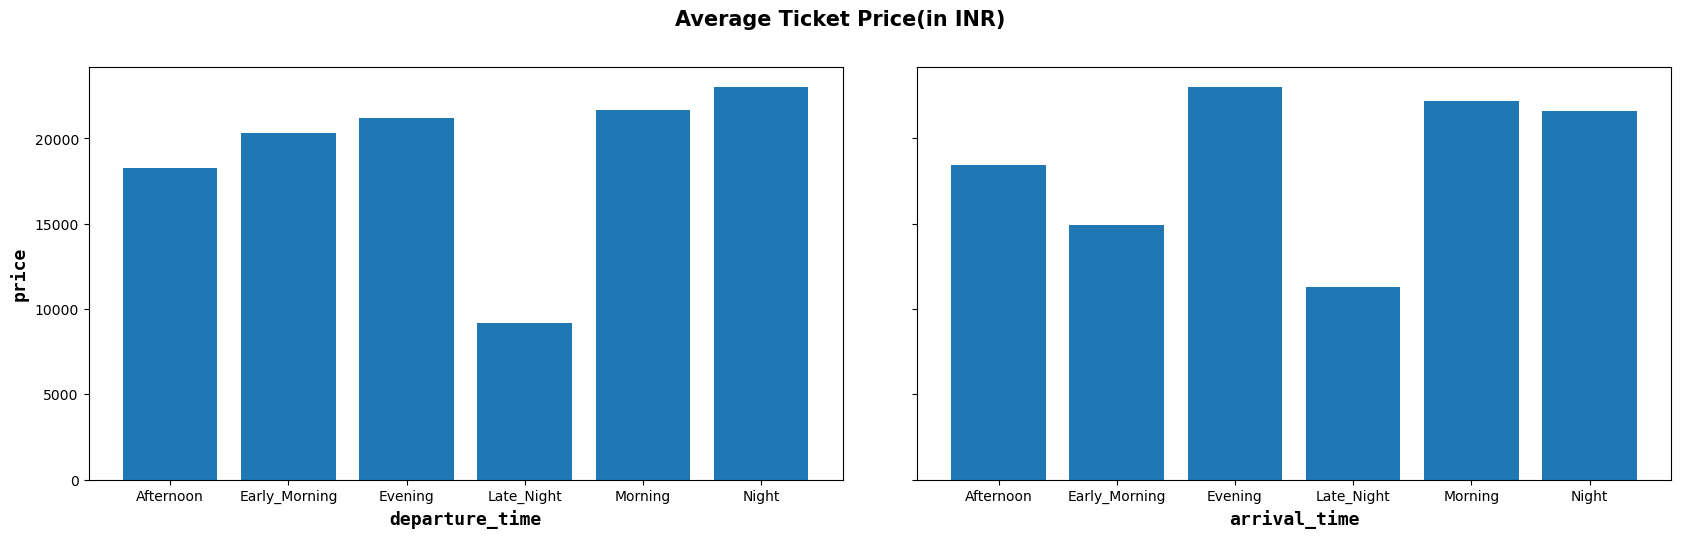

In [9]:
train_concat = pd.concat([X_train, y_train], axis=1)
departure_grouped = train_concat.groupby('departure_time')['price'].mean()
arrival_grouped = train_concat.groupby('arrival_time')['price'].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
fontdict = {'family': 'monospace', 'weight': 'bold', 'size': 13}
axes[0].bar(departure_grouped.index, departure_grouped.values)
axes[0].set_xlabel('departure_time', fontdict=fontdict)
axes[0].set_ylabel('price', fontdict=fontdict)
axes[1].bar(arrival_grouped.index, arrival_grouped.values)
axes[1].set_xlabel('arrival_time', fontdict=fontdict)
fig.tight_layout(pad=5)
plt.suptitle('Average Ticket Price(in INR)', fontweight='bold', size=15)
plt.show()

We'll start with encoding the 'departure_time' and 'arrival_time' columns. We can see that these two features are ordinal categories. We'll sort the categories in order and use OrdinalEncoder to encode 'Early_Morning' to 0, 'Morning' to 1, 'Afternoon' to 2 and so on.

In [10]:
#  Ordinal features
time_categories = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']
enc = OrdinalEncoder(categories=[time_categories, time_categories])
X_train[['departure_time', 'arrival_time']] = enc.fit_transform(X_train[['departure_time', 'arrival_time']])
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
148417,Air_India,AI-424,Kolkata,2.0,one,1.0,Chennai,Economy,19.42,6
36879,Indigo,6E-2193,Delhi,2.0,two_or_more,4.0,Chennai,Economy,7.00,13
274531,Air_India,AI-768,Kolkata,2.0,one,2.0,Chennai,Business,21.17,44
166397,Vistara,UK-876,Hyderabad,4.0,one,0.0,Bangalore,Economy,10.25,11
272722,Vistara,UK-774,Kolkata,4.0,one,4.0,Chennai,Business,26.50,5


We'll then apply the transformation to the test set.

In [11]:
X_test[['departure_time', 'arrival_time']] = enc.transform(X_test[['departure_time', 'arrival_time']])
X_test.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
27131,Air_India,AI-506,Delhi,1.0,one,0.0,Kolkata,Economy,19.75,40
266857,Vistara,UK-706,Kolkata,1.0,one,4.0,Mumbai,Business,9.83,42
141228,Vistara,UK-772,Kolkata,1.0,one,4.0,Bangalore,Economy,10.50,41
288329,Vistara,UK-824,Chennai,4.0,one,1.0,Delhi,Business,14.50,14
97334,Air_India,AI-501,Bangalore,2.0,one,4.0,Mumbai,Economy,8.25,20


Now that we have encoded these two categorical features into numeric features, we can use them (as well as the previous two numeric features, 'duration' and 'days_left') to predict the price.

In [12]:
get_rmse()

Number of features used: 4
RMSE: 22119.532 INR


The RMSE remains at 22k INR, which means the 'departure_time' and 'arrival_time' columns do not help much in predicting the price. Let's proceed with the 'stops' feature. We'll repeat the same process that we did for the previous two columns. 

### 'stops'

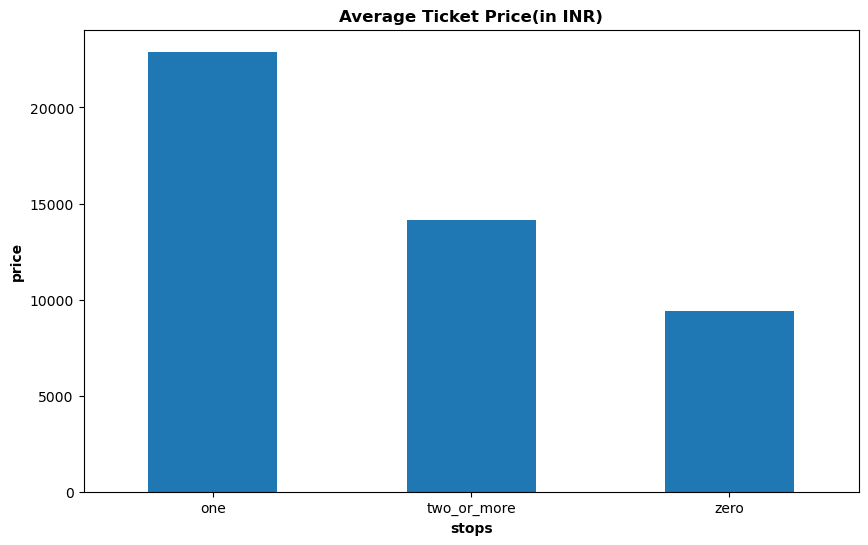

In [13]:
plt.figure(figsize=(10,6))
stops_grouped = train_concat.groupby('stops')['price'].mean()
stops_grouped.plot.bar(stops_grouped.index, stops_grouped.values)
plt.xlabel('stops', weight='bold')
plt.ylabel('price', weight='bold')
plt.title('Average Ticket Price(in INR)', weight='bold')
plt.xticks(rotation='horizontal');

In [14]:
#  Ordinal feature
stops_categories = ['zero', 'one', 'two_or_more']
enc = OrdinalEncoder(categories=[stops_categories])
X_train['stops'] = enc.fit_transform(X_train[['stops']])
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
148417,Air_India,AI-424,Kolkata,2.0,1.0,1.0,Chennai,Economy,19.42,6
36879,Indigo,6E-2193,Delhi,2.0,2.0,4.0,Chennai,Economy,7.00,13
274531,Air_India,AI-768,Kolkata,2.0,1.0,2.0,Chennai,Business,21.17,44
166397,Vistara,UK-876,Hyderabad,4.0,1.0,0.0,Bangalore,Economy,10.25,11
272722,Vistara,UK-774,Kolkata,4.0,1.0,4.0,Chennai,Business,26.50,5


In [15]:
X_test['stops'] = enc.transform(X_test[['stops']])
X_test.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
27131,Air_India,AI-506,Delhi,1.0,1.0,0.0,Kolkata,Economy,19.75,40
266857,Vistara,UK-706,Kolkata,1.0,1.0,4.0,Mumbai,Business,9.83,42
141228,Vistara,UK-772,Kolkata,1.0,1.0,4.0,Bangalore,Economy,10.50,41
288329,Vistara,UK-824,Chennai,4.0,1.0,1.0,Delhi,Business,14.50,14
97334,Air_India,AI-501,Bangalore,2.0,1.0,4.0,Mumbai,Economy,8.25,20


In [16]:
get_rmse()

Number of features used: 5
RMSE: 22112.742 INR


Again, the RMSE remains pretty much the same, meaning the 'stops' feature does not really help in predicting the price. We'll repeat the same process for the 'class' feature.

### 'class'

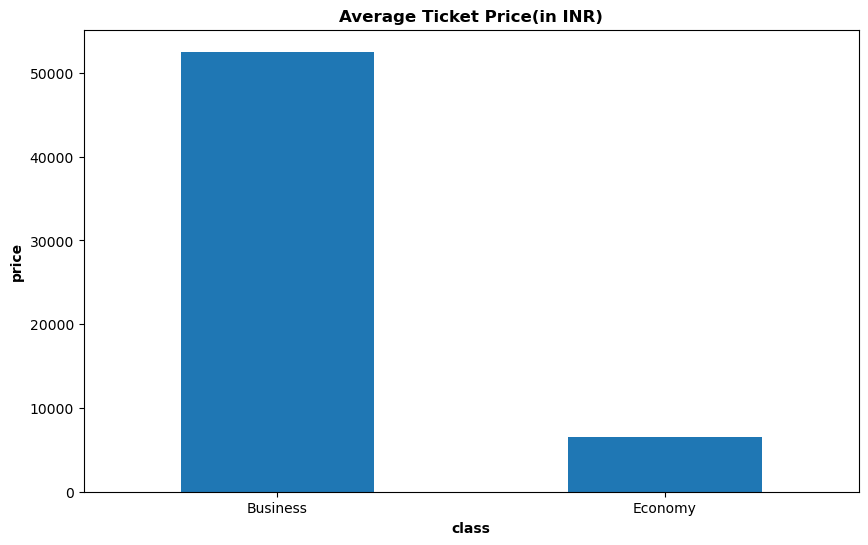

In [17]:
plt.figure(figsize=(10,6))
class_grouped = train_concat.groupby('class')['price'].mean()
class_grouped.plot.bar(class_grouped.index, class_grouped.values)
plt.xlabel('class', weight='bold')
plt.ylabel('price', weight='bold')
plt.title('Average Ticket Price(in INR)', weight='bold')
plt.xticks(rotation='horizontal');


Since there are only two categories, we just need to replace the values with 0 and 1. The order does not matter here.

In [18]:
class_categories = ['Business', 'Economy']
enc = OrdinalEncoder(categories=[class_categories])
X_train['class'] = enc.fit_transform(X_train[['class']])
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
148417,Air_India,AI-424,Kolkata,2.0,1.0,1.0,Chennai,1.0,19.42,6
36879,Indigo,6E-2193,Delhi,2.0,2.0,4.0,Chennai,1.0,7.00,13
274531,Air_India,AI-768,Kolkata,2.0,1.0,2.0,Chennai,0.0,21.17,44
166397,Vistara,UK-876,Hyderabad,4.0,1.0,0.0,Bangalore,1.0,10.25,11
272722,Vistara,UK-774,Kolkata,4.0,1.0,4.0,Chennai,0.0,26.50,5


In [19]:
X_test['class'] = enc.transform(X_test[['class']])
X_test.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
27131,Air_India,AI-506,Delhi,1.0,1.0,0.0,Kolkata,1.0,19.75,40
266857,Vistara,UK-706,Kolkata,1.0,1.0,4.0,Mumbai,0.0,9.83,42
141228,Vistara,UK-772,Kolkata,1.0,1.0,4.0,Bangalore,1.0,10.50,41
288329,Vistara,UK-824,Chennai,4.0,1.0,1.0,Delhi,0.0,14.50,14
97334,Air_India,AI-501,Bangalore,2.0,1.0,4.0,Mumbai,1.0,8.25,20


In [20]:
get_rmse()

Number of features used: 6
RMSE: 7164.326 INR


Unsurprisingly, after including the 'class' column to our model, the RMSE drops drastically to 7k INR(~RM384). This shows the 'class' feature correlates the most(so far) with the price. Let's proceed with the remaining features and see if we can still drastically improve the model performance.

### 'airline', 'source_city' and 'destination_city'

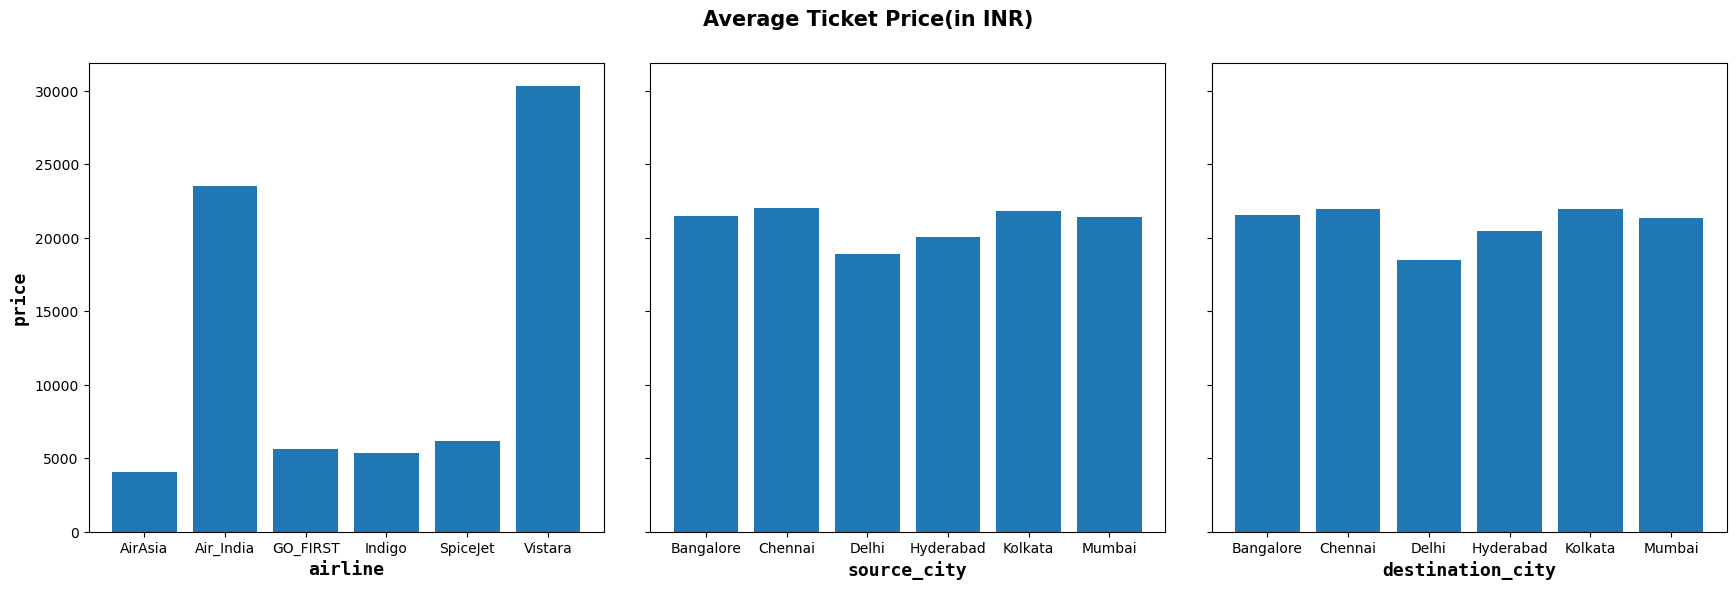

In [21]:
airline_grouped = train_concat.groupby('airline')['price'].mean()
source_grouped = train_concat.groupby('source_city')['price'].mean()
destination_grouped = train_concat.groupby('destination_city')['price'].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 6),sharey=True)
fontdict = {'family': 'monospace', 'weight': 'bold', 'size': 13}
axes[0].bar(airline_grouped.index, airline_grouped.values)
axes[0].set_xlabel('airline', fontdict=fontdict)
axes[0].set_ylabel('price', fontdict=fontdict)
axes[1].bar(source_grouped.index, source_grouped.values)
axes[1].set_xlabel('source_city', fontdict=fontdict)
axes[2].bar(destination_grouped.index, destination_grouped.values)
axes[2].set_xlabel('destination_city', fontdict=fontdict)
fig.tight_layout(pad=3)
plt.suptitle('Average Ticket Price(in INR)', fontweight='bold', size=15, y=1.02)
plt.show()

We can see that these features are nominal data, since there's no natural order or rank between them. For these features, we can use OneHotEncoder, where we will create a binary attribute for each category.

In [22]:
# Nominal Features
from sklearn.preprocessing import OneHotEncoder
ohe_cols = ['airline', 'source_city', 'destination_city']
enc = OneHotEncoder(handle_unknown='ignore')
X_train[enc.categories_[0].tolist() +
        ('source_' + enc.categories_[1]).tolist() + 
        ('destination_' + enc.categories_[2]).tolist()] = enc.fit_transform(X_train[ohe_cols]).toarray()
X_train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,AirAsia,Air_India,GO_FIRST,Indigo,SpiceJet,Vistara,source_Bangalore,source_Chennai,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,destination_Bangalore,destination_Chennai,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_Mumbai
148417,Air_India,AI-424,Kolkata,2.0,1.0,1.0,Chennai,1.0,19.42,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36879,Indigo,6E-2193,Delhi,2.0,2.0,4.0,Chennai,1.0,7.00,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
274531,Air_India,AI-768,Kolkata,2.0,1.0,2.0,Chennai,0.0,21.17,44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
166397,Vistara,UK-876,Hyderabad,4.0,1.0,0.0,Bangalore,1.0,10.25,11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
272722,Vistara,UK-774,Kolkata,4.0,1.0,4.0,Chennai,0.0,26.50,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
X_test[enc.categories_[0].tolist() + 
       ('source_' + enc.categories_[1]).tolist() + 
       ('destination_' + enc.categories_[2]).tolist()] = enc.transform(X_test[ohe_cols]).toarray()
X_test.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,AirAsia,Air_India,GO_FIRST,Indigo,SpiceJet,Vistara,source_Bangalore,source_Chennai,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,destination_Bangalore,destination_Chennai,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_Mumbai
27131,Air_India,AI-506,Delhi,1.0,1.0,0.0,Kolkata,1.0,19.75,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
266857,Vistara,UK-706,Kolkata,1.0,1.0,4.0,Mumbai,0.0,9.83,42,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
141228,Vistara,UK-772,Kolkata,1.0,1.0,4.0,Bangalore,1.0,10.50,41,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
288329,Vistara,UK-824,Chennai,4.0,1.0,1.0,Delhi,0.0,14.50,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
97334,Air_India,AI-501,Bangalore,2.0,1.0,4.0,Mumbai,1.0,8.25,20,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
get_rmse()

Number of features used: 24
RMSE: 6826.287 INR


The RMSE drops a little bit to 6.8k INR(~RM365). There's another feature that we have not touched, which is the 'flight' feature, but we will not consider it here since it has over 1500 unique categories.

## FEATURE SCALING

Eventhough we have succesfully converted all categorial features into numeric values(apart from the 'flight' column), it's important to note that all the features have different scales. For example, the 'class' column ranges from 0 to 1, while the 'days_left' column ranges from 1 to 49, as can be seen below:

In [25]:
X_train[['class', 'days_left']].describe().loc[['min', 'max']]

,class,days_left
min,0.0,1.0
max,1.0,49.0


The scale differences may or may not affect our model performance. To standardize the different scales, we can use StandardScaler where it rescales each feature such that it has a standard deviation of 1 and a mean of 0.

In [26]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train.select_dtypes(include='number'))
scaled_X_test = scaler.transform(X_test.select_dtypes(include='number'))

Now, we can re-evaluate our model performance using the scaled training and testing set.

In [27]:
model = LinearRegression().fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

RMSE = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {RMSE:.3f} INR')

RMSE: 6826.265 INR


In our case, scaling the features barely makes a difference as the RMSE stays at 6826 INR(~RM365). Below is a dataframe that contains the actual prices and the predicted prices.

In [28]:
df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred.round(3)})
df

,Actual Price,Predicted Price
27131,7366,3652.856
266857,64831,54679.506
141228,6195,9686.024
288329,60160,54376.321
97334,6578,6651.537
...,...,...
5234,5026,4388.537
5591,3001,-106.275
168314,6734,4507.305
175191,5082,-671.582


## CONCLUSION

On average, our predicted price differs from the actual price by 6826 INR(~RM365). The 'class' feature is the feature that helps the most in improving our model as it drastically reduces the RMSE from 22k INR to 7k INR.